### 定义模型

注意DDPG中critic网络的输入是state加上action。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim = 256, init_w=3e-3):
        super(Actor, self).__init__()  
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, action_dim)
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x
        
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256, init_w=3e-3):
        super(Critic, self).__init__()
        
        self.linear1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        # 随机初始化为较小的值
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        # 按维数1拼接
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

### 定义经验回放

In [2]:
from collections import deque
import random
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        '''_summary_
        Args:
            trainsitions (tuple): _description_
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if sequential: # sequential sampling
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else:
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        self.buffer.clear()
    def __len__(self):
        return len(self.buffer)

### 定义策略

In [3]:
import numpy as np

class Policy(object):
	def __init__(self,cfg):
		self.gamma = cfg.gamma # 奖励的折扣因子
		self.actor_lr = cfg.actor_lr # actor学习率
		self.critic_lr = cfg.critic_lr # critic学习率
		self.policy_noise = cfg.policy_noise
		self.noise_clip = cfg.noise_clip
		self.expl_noise = cfg.expl_noise
		self.policy_freq = cfg.policy_freq
		self.batch_size =  cfg.batch_size 
		self.tau = cfg.tau
		self.sample_count = 0
		self.update_count = 0
		self.policy_freq = cfg.policy_freq
		self.explore_steps = cfg.explore_steps
		self.action_dim = cfg.action_dim
		self.action_space = cfg.action_space
		self.action_high = cfg.action_space.high[0]
		self.action_low = cfg.action_space.low[0]
		self.action_scale = (self.action_high - self.action_low) / 2
		self.action_bias = (self.action_high + self.action_low) / 2
		self.device = torch.device(cfg.device)
		
		self.actor = Actor(cfg.state_dim, cfg.action_dim, hidden_dim = cfg.actor_hidden_dim).to(self.device)
		self.actor_target = Actor(cfg.state_dim, cfg.action_dim, hidden_dim = cfg.actor_hidden_dim).to(self.device)
		self.critic_1 = Critic(cfg.state_dim, cfg.action_dim, hidden_dim = cfg.critic_hidden_dim).to(self.device)
		self.critic_2 = Critic(cfg.state_dim, cfg.action_dim, hidden_dim = cfg.critic_hidden_dim).to(self.device)
		self.critic_1_target = Critic(cfg.state_dim, cfg.action_dim, hidden_dim = cfg.critic_hidden_dim).to(self.device)
		self.critic_2_target = Critic(cfg.state_dim, cfg.action_dim, hidden_dim = cfg.critic_hidden_dim).to(self.device)
		# 复制参数到目标网络
		self.actor_target.load_state_dict(self.actor.state_dict()) 
		self.critic_1_target.load_state_dict(self.critic_1.state_dict())
		self.critic_2_target.load_state_dict(self.critic_2.state_dict())
		
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = self.actor_lr)
		self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr = self.critic_lr)
		self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr = self.critic_lr)
		self.memory = ReplayBuffer(cfg.buffer_size)
		# self.memory = ReplayBuffer(state_dim, action_dim)

	def sample_action(self, state):
		''' 采样动作
		'''
		self.sample_count += 1
		if self.sample_count < self.explore_steps:
			return self.action_space.sample()
		else:
			state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
			action = self.actor(state)
			action = self.action_scale * action + self.action_bias
			action = action.detach().cpu().numpy()[0]
			action_noise = np.random.normal(0, self.action_scale * self.expl_noise, size=self.action_dim)
			action = (action + action_noise).clip(self.action_space.low, self.action_space.high)
			return action

	@torch.no_grad()
	def predict_action(self, state):
		''' 预测动作
		'''
		state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
		action = self.actor(state)
		action = self.action_scale * action + self.action_bias # 对actor计算的动作分布放缩
		return action.detach().cpu().numpy()[0]

	def update(self):
		# if len(self.memory) < self.batch_size:
		# 	return
		if len(self.memory) < self.explore_steps: # 当经验回放中不满足一个批量时，不更新策略
			return
		state, action, reward, next_state, done = self.memory.sample(self.batch_size) # 从经验回放中随机采样一个批量的转移(transition)
         # 将数据转换为tensor
		state = torch.tensor(np.array(state), device=self.device, dtype=torch.float32)
		action = torch.tensor(np.array(action), device=self.device, dtype=torch.float32)
		next_state = torch.tensor(np.array(next_state), device=self.device, dtype=torch.float32)
		reward = torch.tensor(reward, device=self.device, dtype=torch.float32).unsqueeze(1)
		done = torch.tensor(done, device=self.device, dtype=torch.float32).unsqueeze(1)
		# update critic
		# noise = (torch.randn_like(action) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip) # 构造加入目标动作的噪声
        # 计算加入了噪声的目标动作
		next_action = self.actor_target(next_state)
		# next_action = (self.actor_target(next_state) + noise).clamp(-self.action_scale+self.action_bias, self.action_scale+self.action_bias)
        # 计算两个critic网络对t+1时刻的状态动作对的评分，并选取更小值来计算目标q值
		target_q1, target_q2 = self.critic_1_target(next_state, next_action).detach(), self.critic_2_target(next_state, next_action).detach()
		target_q = torch.min(target_q1, target_q2)
		target_q = reward + self.gamma * target_q * (1 - done)
        # 计算两个critic网络对t时刻的状态动作对的评分
		current_q1, current_q2 = self.critic_1(state, action), self.critic_2(state, action)
        # 计算均方根损失
		critic_1_loss = F.mse_loss(current_q1, target_q)
		critic_2_loss = F.mse_loss(current_q2, target_q)
		self.critic_1_optimizer.zero_grad()
		critic_1_loss.backward()
		self.critic_1_optimizer.step()
		self.critic_2_optimizer.zero_grad()
		critic_2_loss.backward()
		self.critic_2_optimizer.step()
		for param, target_param in zip(self.critic_1.parameters(), self.critic_1_target.parameters()):
			target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
		for param, target_param in zip(self.critic_2.parameters(), self.critic_2_target.parameters()):
			target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
		if self.update_count % self.policy_freq == 0:
            # 延迟策略更新，actor的更新频率低于critic
			actor_loss = -self.critic_1(state, self.actor(state)).mean()
			self.actor_optimizer.zero_grad()
			actor_loss.backward()
			self.actor_optimizer.step()
            #目标网络软更新
			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
		self.update_count += 1
			


### 定义训练

In [4]:


import gymnasium as gym

def train(cfg):
    env = gym.make(cfg.env_id)
    setattr(cfg, "action_space", env.action_space)
    setattr(cfg, "state_dim", env.observation_space.shape[0])
    setattr(cfg, "action_dim", env.action_space.shape[0])
    policy = Policy(cfg)
    rewards,frames = [],[]
    for i_ep in range(cfg.train_eps):
        state, _ = env.reset()
        ep_reward = 0
        for i_step in range(cfg.max_steps):
            action = policy.sample_action(state)
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            policy.memory.push((state, action, reward, next_state, truncated))  # 保存transition
            state = next_state  # 更新下一个状态
            ep_reward += reward
            policy.memory.push((state, action, reward, next_state, truncated))
            policy.update()
            state = next_state
            if truncated:
                break
        rewards.append(ep_reward)
        frames.append(i_ep)
        if (i_ep+1)%10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}")
    env.close()
    return {'rewards':rewards, 'frames':frames}

### 设置参数

In [5]:
class Config:
    def __init__(self):
        self.algo_name = 'TD3' # 算法名称
        self.env_id = 'Pendulum-v1' # 环境名称
        self.mode = 'train'
        self.seed = 1 # 随机种子
        self.train_eps = 100 # 训练迭代次数
        self.test_eps = 20 # 测试迭代次数
        self.eval_eps = 10 # 评估迭代次数
        self.eval_per_episode = 5 # 每隔几代评估
        self.explore_steps = 100 # 探索步数
        self.max_steps = 200 # 每次迭代最大时间步
        self.policy_freq = 2  # 策略网络更新频率
        self.actor_lr = 1e-3 
        self.critic_lr = 1e-3 
        self.actor_hidden_dim = 256 # actor网络隐藏层维度
        self.critic_hidden_dim = 256 # critic网络隐藏层维度
        self.gamma = 0.99 
        self.tau = 0.005 # 目标网络软更新系数
        self.policy_noise = 0.2 # 加入策略网络的噪声
        self.expl_noise = 0.1 # 高斯噪声标准差
        self.noise_clip = 0.5 # 加入策略网络噪声范围
        self.batch_size = 100 # 训练批次大小
        self.buffer_size = 8000 # 经验回放池大小
        self.device = 'cpu' if not torch.cuda.is_available() else 'cuda' # 训练设备

### 开始训练

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def smooth(data: list, weight: float = 0.9):
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(cfg, frames, rewards):
    ''' 画图
    '''
    sns.set_theme(style="darkgrid")
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{cfg.mode}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
    plt.xlabel('frames')
    plt.plot(frames, rewards, label='rewards')
    plt.plot(frames, smooth(rewards), label='smoothed rewards')
    plt.legend()
    plt.show()

def print_cfgs(cfg):
    ''' 打印参数
    '''
    cfg_dict = vars(cfg)
    print("Hyperparameters:")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in cfg_dict.items():
        if v.__class__.__name__ == 'list':
            v = str(v)
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))

def all_seed(seed: int = 0):
    ''' 设置随机种子
    '''
    if seed == 0:
        return
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False  

Hyperparameters:
        Name        	       Value        	        Type        
     algo_name      	        TD3         	   <class 'str'>    
       env_id       	    Pendulum-v1     	   <class 'str'>    
        mode        	       train        	   <class 'str'>    
        seed        	         1          	   <class 'int'>    
     train_eps      	        100         	   <class 'int'>    
      test_eps      	         20         	   <class 'int'>    
      eval_eps      	         10         	   <class 'int'>    
  eval_per_episode  	         5          	   <class 'int'>    
   explore_steps    	        100         	   <class 'int'>    
     max_steps      	        200         	   <class 'int'>    
    policy_freq     	         2          	   <class 'int'>    
      actor_lr      	       0.001        	  <class 'float'>   
     critic_lr      	       0.001        	  <class 'float'>   
  actor_hidden_dim  	        256         	   <class 'int'>    
 critic_hidden_dim  	        256      

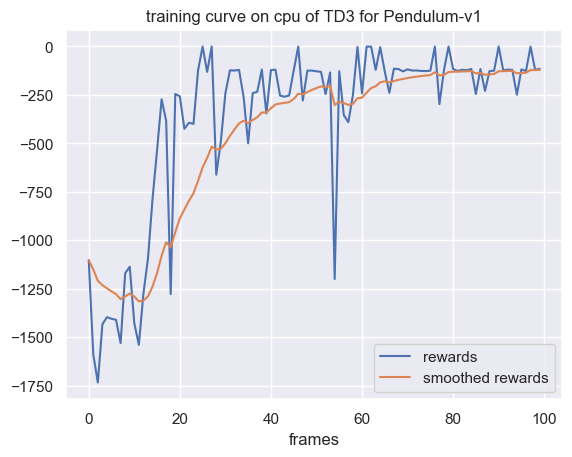

In [7]:
# 获取参数
cfg = Config() 
all_seed(cfg.seed)
print_cfgs(cfg)
res = train(cfg)
plot_rewards(cfg, res['frames'], res['rewards'])